# SED

### Imports

In [1]:
import inspect
import json
import types
import abc
import numpy as np
from bigraph_viz import plot_bigraph, plot_flow, pf
from bigraph_viz.dict_utils import schema_keys

schema_keys.extend(['_id', 'config'])

### Registry and Decorators

In [2]:
# decorators
def register(registry, identifier=None):
    def decorator(func):
        registry.register(func, identifier=identifier)
        return func
    return decorator


def annotate(annotation):
    def decorator(func):
        func.annotation = annotation
        return func
    return decorator


# TODO: ports for functions require input/output, but for processes this isn't required
# TODO assert type are in type_registry
# TODO check that keys match function signature
def ports(ports_schema):
    # assert inputs/outputs and types, give suggestions
    allowed = ['inputs', 'outputs']
    assert all(key in allowed for key in
               ports_schema.keys()), f'{[key for key in ports_schema.keys() if key not in allowed]} not allowed as top-level port keys. Allowed keys include {str(allowed)}'
    def decorator(func):
        func.ports = ports_schema
        return func
    return decorator


# registry
class ProcessRegistry:
    def __init__(self):
        self.registry = {}

    def register(self, process, identifier=None):
        if not identifier:
            identifier = process.__name__
        signature = inspect.signature(process)
        annotation = getattr(process, 'annotation', None)
        ports = getattr(process, 'ports')
        
        try:
            bases = [base.__name__ for base in process.__bases__]
        except:
            bases = None
        process_type = None
        if isinstance(process, types.FunctionType):
            process_type = 'function'
        elif 'Composite' in bases:
            process_type = 'composite'
        elif 'Process' in bases:
            process_type = 'process'

        # TODO -- assert ports and signature match
        if not annotation:
            raise Exception(f'Process {identifier} requires annotations')
        if not ports:
            raise Exception(f'Process {identifier} requires annotations')

        item = {
            'annotation': annotation,
            'ports': ports,
            'address': process,
            'type': process_type,
        }
        self.registry[identifier] = item

    def access(self, name):
        return self.registry.get(name)

    def get_annotations(self):
        return [v.get('annotation') for k, v in self.registry.items()]

    def activate_process(self, process_name, namespace):
        namespace[process_name] = self.registry[process_name]['address']

    def activate_all(self, namespace):
        """how to add to globals: process_registry.activate_all(globals())"""
        for process_name in self.registry.keys():
            self.activate_process(process_name, namespace)


# initialize a registry
sed_process_registry = ProcessRegistry()

In [3]:
def serialize_instance(wiring):
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        raise TypeError(f'Object of type "{obj.__class__.__name__}" is not JSON serializable')
    return json.dumps(wiring, default=convert_numpy)


def deserialize_instance(serialized_wiring):
    if isinstance(serialized_wiring, dict):
        return serialized_wiring
    def convert_numpy(obj):
        if isinstance(obj, list):
            return np.array(obj)
        return obj
    return json.loads(serialized_wiring, object_hook=convert_numpy)


def initialize_process_from_schema(schema, process_registry):
    schema = deserialize_instance(schema)
    assert len(schema) == 1  # only one top-level key
    process_name = next(iter(schema))
    process_entry = process_registry.access(process_name)
    process = process_entry['address']  # get the process from registry
    config = schema[process_name]['config']
    return {process_name: process(config=config, process_registry=process_registry)}


def get_processes_states_from_schema(schema, process_registry):
    all_annotations = process_registry.get_annotations()
    processes = {}
    states = {}
    for name, value in schema.items():
        if isinstance(value, dict) and value.get('wires'):
            processes[name] = value
        else:
            states[name] = value
    return processes, states


### Process and Composite base class

In [4]:
class Process:
    config = {}
    
    def __init__(self, config):
        self.initialize(config)
        
    def initialize(self, config):
        self.config = config
    
    @abc.abstractmethod
    def ports(self):
        return {}
    
    @abc.abstractmethod
    def update(self, state):
        return {}
    
    
class Composite(Process):
    config = {}

    def __init__(self, config, process_registry):
        self.initialize(config, process_registry)
        
    def initialize(self, config, process_registry):
        self.config = config
        self.process_registry = process_registry
        processes, states = get_processes_states_from_schema(
            self.config, self.process_registry)
        self.states = states
        self.processes = {}
        for process in processes:
            process_schema = {process: self.config[process]}
            initialized_process = initialize_process_from_schema(
                process_schema, process_registry)
            self.processes.update(initialized_process)
            
    def process_state(self, process_path):
        # TODO -- get the state from the point of view of the process
        return
    
    def to_json(self):
        return serialize_instance(self.config)
    
    @abc.abstractmethod
    def run(self):
        return {}
    
 

## Examples

### Make Processes/Composites for examples

In [5]:
@register(
    identifier='loop', 
    registry=sed_process_registry)
@ports({
    'inputs': {
        'trials': 'int'},
    'outputs': {
        'results': 'list'}})
@annotate('sed:range_iterator')
class RangeIterator(Composite):
    def run(self, trials):
        results = []
        for i in range(trials):
            for process in self.processes:
                # TODO -- get the process state
                result = process.update()
        return results

    
@register(
    identifier='sum', 
    registry=sed_process_registry)
@ports({
    'inputs': {'values': 'list[float]'}, 
    'outputs': {'c': 'float'}})
@annotate('math:add')
def add_list(values):
    return sum(values)
    
    
print(pf(sed_process_registry.registry))

{ 'loop': { 'address': <class '__main__.RangeIterator'>,
            'annotation': 'sed:range_iterator',
            'ports': { 'inputs': {'trials': 'int'},
                       'outputs': {'results': 'list'}},
            'type': 'composite'},
  'sum': { 'address': <function add_list at 0x1271f4b80>,
           'annotation': 'math:add',
           'ports': { 'inputs': {'values': 'list[float]'},
                      'outputs': {'c': 'float'}},
           'type': 'function'}}


### Instance

In [6]:
config1 = {
    'trials': 10,
    'loop': {
        '_id': 'loop',
        '_type': 'sed:range_iterator',
        'wires': {
            'trials': 'trials',
        },
        'config': {},
        'value': 0,
        'added': 1,
        'add': {
            '_type': 'math:add',
            '_id': 'sum',
            'wires': {
                'a': 'value',
                'b': 'added',
                'result': 'value',
            },
        }
    },

}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str1 = serialize_instance(config1)
# print(json_str1)

sim_experiment = Composite(
    config=config1, 
    process_registry=sed_process_registry)

sim_experiment.run()

json_str = sim_experiment.to_json()
# print(pf(json_str))

In [7]:
print(pf(sim_experiment.config))

{ 'loop': { '_id': 'loop',
            '_type': 'sed:range_iterator',
            'add': { '_id': 'sum',
                     '_type': 'math:add',
                     'wires': {'a': 'value', 'b': 'added', 'result': 'value'}},
            'added': 1,
            'config': {},
            'value': 0,
            'wires': {'trials': 'trials'}},
  'trials': 10}


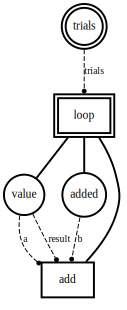

In [9]:
plot_bigraph(config1)

## Infix

In [10]:
import numpy as np
import re

def infix_to_postfix(infix_expression):
    precedence = {'+':1, '-':1, '*':2, '/':2, '^':3}
    right_associative = {'^'}
    stack = [] 
    postfix = []
    
    # Tokenizing the infix expression
    tokens = re.findall(r"[\w.]+|[^ \w]", infix_expression)

    for token in tokens:
        if re.match(r"^[\d.]+$", token):  # If the token is a number (integer or float)
            postfix.append(token)
        elif token.startswith('np'):  # If the token is a numpy array
            postfix.append(token)
        elif token == '(':
            stack.append('(')
        elif token == ')':
            while stack and stack[-1] != '(':
                postfix.append(stack.pop())
            if stack:
                stack.pop()
        else:  # If the token is an operator
            while (stack and stack[-1] != '(' and 
                   ((token not in right_associative and precedence.get(token, 0) <= precedence.get(stack[-1], 0)) or
                   (token in right_associative and precedence.get(token, 0) < precedence.get(stack[-1], 0)))):
                postfix.append(stack.pop())
            stack.append(token)

    while stack:
        postfix.append(stack.pop())

    postfix_expression = " ".join(postfix)
    print(f"Postfix Expression: {postfix_expression}")  # Debugging print statement
    return postfix_expression

def evaluate_postfix(postfix_expression):
    stack = []
    tokens = postfix_expression.split()

    for token in tokens:
        if re.match(r"^[\d.]+$", token):  # If the token is a number (integer or float)
            stack.append(float(token))
        elif token.startswith('np'):  # If the token is a numpy array
            stack.append(eval(token))
        else:  # If the token is an operator
            val1 = stack.pop()
            val2 = stack.pop()
            switcher = {
                '+': val2 + val1,
                '-': val2 - val1,
                '*': val2 * val1,
                '/': val2 / val1,
                '^': val2**val1
            }
            stack.append(switcher.get(token))
    
    print(f"Final Stack: {stack}")  # Debugging print statement
    return stack[0]

def evaluate_infix(infix_expression):
    postfix_expression = infix_to_postfix(infix_expression)
    result = evaluate_postfix(postfix_expression)
    return result


In [11]:
# # Test the function
# arr1 = np.array([1, 2, 3])
# arr2 = np.array([4, 5, 6])
# print(stringify_array(arr1))  # Output: "array0"
# print(stringify_array(arr2))  # Output: "array1"

# print(evaluate_infix("(22.112+3.123)*0.245^3.1"))